In [1]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd

Taiwan_QQQ = pd.read_feather("Cleaned_2018_Science.feather")

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Science_level'], axis=1)
y = Taiwan_QQQ['Science_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

RTSN          0.450121
RCUN          0.445340
RCER          0.435688
RTML          0.433784
GLCM          0.431362
                ...   
TEACHINT      0.029216
ST207Q03HA    0.029003
ST012Q09NA    0.028516
ST177Q01HA    0.028478
ST166Q05HA    0.028307
Length: 100, dtype: float64


In [4]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,RTSN,RCUN,RCER,RTML,GLCM,RCLI,JOYREAD,METASUM,METASPAM,ST225Q06HA,...,ST160Q03IA,HISCED_D,ST215Q03HA,IC152Q08HA,EC150Q05WA,TEACHINT,ST207Q03HA,ST012Q09NA,ST177Q01HA,ST166Q05HA
571621,404.5217,375.1557,407.8958,384.5323,453.4855,386.0565,-0.6996,-0.18,-1.41,0.0,...,2.0,5.0,2.0,1.0,1.0,-0.3449,1.0,1.0,1.0,3.0
568626,667.0569,654.8895,639.8344,654.4704,683.6405,629.8557,0.6380,1.36,0.42,1.0,...,3.0,6.0,2.0,4.0,2.0,-0.5905,3.0,2.0,4.0,4.0
572855,579.9832,577.5912,607.1789,613.7438,624.6456,593.1064,-2.7114,0.21,0.42,1.0,...,1.0,5.0,2.0,5.0,2.0,0.2182,3.0,3.0,2.0,1.0
573892,316.2809,336.8350,337.7383,361.7677,393.9244,361.5411,-0.9615,-1.72,-1.41,0.0,...,2.0,5.0,1.0,1.0,2.0,-0.6573,1.0,1.0,1.0,1.0
573109,533.3597,526.8344,548.2182,527.9564,491.5303,518.4995,1.4712,-0.57,-0.04,1.0,...,3.0,5.0,1.0,5.0,2.0,-1.0615,2.0,2.0,1.0,1.0


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}

# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.903364969801553
Fold 2 score: 0.9042277825711821
Fold 3 score: 0.9042277825711821
Fold 4 score: 0.8861087144089732
Fold 5 score: 0.9041450777202072
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5211389128559103
Fold 2 score: 0.5220017256255393
Fold 3 score: 0.5228645383951682
Fold 4 score: 0.5237273511647972
Fold 5 score: 0.5241796200345423
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.8748921484037964
Fold 2 score: 0.8895599654874892
Fold 3 score: 0.902502157031924
Fold 4 score: 0.8645383951682485
Fold 5 score: 0.8911917098445595
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.903364969801553
Fold 2 score: 0.9042277825711821
Fold 3 score: 0.9042277825711821
Fold 4 score: 0.8861087144089732
Fold 5 score: 0.9041450777202072
Params: {'svm__C

In [6]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.8990509059534081
Fold 2 score: 0.902502157031924
Fold 3 score: 0.907679033649698
Fold 4 score: 0.8869715271786023
Fold 5 score: 0.9067357512953368
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.903364969801553
Fold 2 score: 0.903364969801553
Fold 3 score: 0.913718723037101
Fold 4 score: 0.8861087144089732
Fold 5 score: 0.9041450777202072
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.9042277825711821
Fold 2 score: 0.9016393442622951
Fold 3 score: 0.9188955996548749
Fold 4 score: 0.8878343399482312
Fold 5 score: 0.9041450777202072
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.905090595340811
Fold 2 score: 0.903364969801553

In [7]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.8938740293356342
Fold 2 score: 0.902502157031924
Fold 3 score: 0.9042277825711821
Fold 4 score: 0.8766177739430544
Fold 5 score: 0.8981001727115717
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.8904227782571182
Fold 2 score: 0.903364969801553
Fold 3 score: 0.905090595340811
Fold 4 score: 0.8800690250215704
Fold 5 score: 0.8963730569948186
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.8964624676445211
Fold 2 score: 0.9007765314926661
Fold 3 score: 0.9068162208800691
Fold 4 score: 0.8852459016393442
Fold 5 score: 0.9041450777202072
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.8938740293356342
Fold 2 score: 0.902502157031924
Fold 3 score: 0

In [8]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7860224331320104
Fold 2 score: 0.7333908541846419
Fold 3 score: 0.7463330457290768
Fold 4 score: 0.731665228645384
Fold 5 score: 0.7426597582037997
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.7937877480586712
Fold 2 score: 0.7377049180327869
Fold 3 score: 0.7540983606557377
Fold 4 score: 0.7368421052631579
Fold 5 score: 0.7461139896373057
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.7929249352890423
Fold 2 score: 0.7368421052631579
Fold 3 score: 0.7532355478861087
Fold 4 score: 0.7368421052631579
Fold 5 score: 0.7469775474956822
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.7937877480586712
Fold 2 score: 0.7377049180327869
Fold 3 score: 0.7540983606557377
Fold 4 score: 0.7368421052631579
Fold 5 score: 0.7461139896373057
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.7929249352890423
Fold 2 score: 0.7377049180327869
Fold 3 score: 0.7540983606557377
Fold 4 score: 0.7368421052631579
Fold 5 score: 0.7461139896373

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.8964803312629399

In [10]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

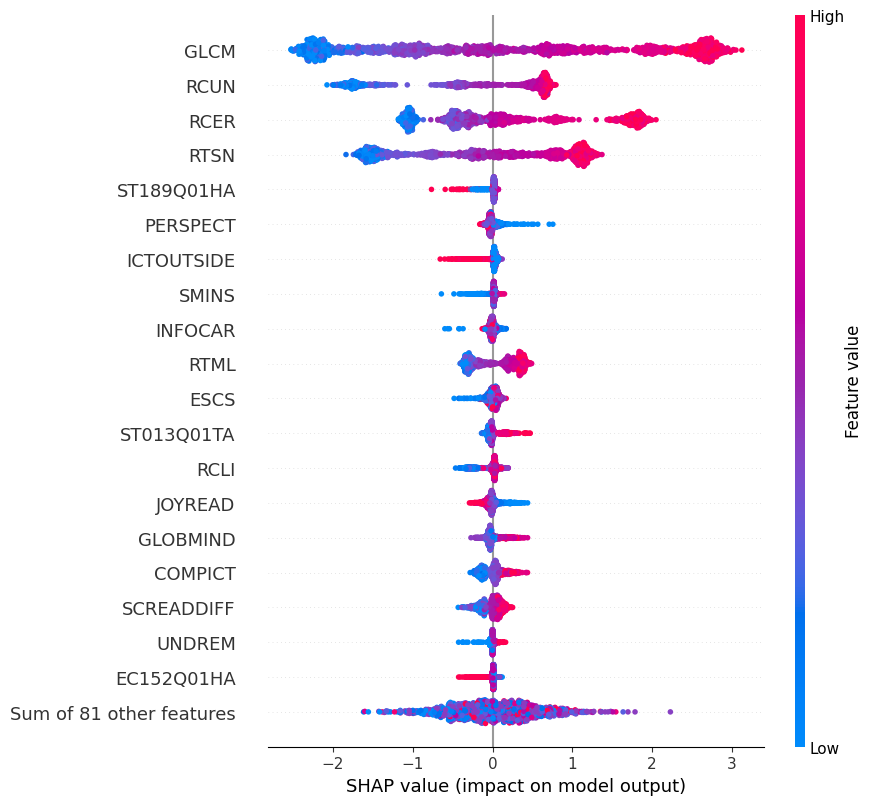

In [11]:
shap.plots.beeswarm(shap_values,max_display=20,order=shap_values.abs.max(0))